### MasaCtrl: Tuning-free Mutual Self-Attention Control for Consistent Image Synthesis and Editing

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import numpy as np

from tqdm import tqdm
from einops import rearrange, repeat
from omegaconf import OmegaConf

from diffusers import DDIMScheduler, StableDiffusionPipeline
from diffusers.utils.torch_utils import randn_tensor
from masactrl.diffuser_utils import MasaCtrlPipeline
from masactrl.masactrl_utils import AttentionBase
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/home/user01/.conda/envs/pytorch2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Model Construction

In [2]:
# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model_path = "xyn-ai/anything-v4.0"
model_path = "/home/user01/SD2-1-base"
# model_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(
    "/home/user01/SD2-1-base",
    scheduler=scheduler,
    custom_pipeline="/home/user01/MyREMOVAL/pipeline_mine.py",
    torch_dtype=torch.float16
)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]
/home/user01/.cache/huggingface/modules/diffusers_modules/local/pipeline_mine.py:203: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would

In [3]:
from masactrl.masactrl import MutualSelfAttentionControl,MutualSelfAttentionControlMask_An
from torchvision.io import read_image


def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(torch.float16).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512))
    mask = mask.to(torch.float16).to(device)
    return mask

seed = 321
seed_everything(seed)
sample = "22"
out_dir = f"./workdir/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"/home/user01/MyREMOVAL/examples/img/{sample}.png"
MASK_PATH = f"/home/user01/MyREMOVAL/examples/mask/{sample}_mask.png"
#SOURCE_IMAGE_PATH = "/home/user01/AnonymousEditing/examples/img/an.png"
#MASK_PATH = "/home/user01/AnonymousEditing/examples/mask/an_mask.png"
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask = load_mask(MASK_PATH, device)


Seed set to 321


In [4]:
source_prompt = ""
target_prompt = ""
prompts = [source_prompt, target_prompt]
with torch.no_grad():
    # invert the source image
    start_code, latents_list,pred_x0_list = pipe.invert(
                                source_image,
                                mask,
                                source_prompt,
                                guidance_scale=1,
                                num_inference_steps=50,
                                return_intermediates=True)

DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


In [5]:
"""  # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(pred_x0_list[30:40][i])
    ax.axis('off')  # 隐藏坐标轴

plt.show()  """

"  # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)\nfig, axs = plt.subplots(2, 5, figsize=(15, 6))\n\nfor i, ax in enumerate(axs.flatten()):\n    ax.imshow(pred_x0_list[30:40][i])\n    ax.axis('off')  # 隐藏坐标轴\n\nplt.show()  "

In [6]:
generator = torch.manual_seed(seed)
random_input = randn_tensor(shape=(1,4,64,64),generator=generator, device=device, dtype=torch.float16)
latent_input = start_code
test_mask = F.max_pool2d(mask, (8, 8)).round()
input = test_mask*random_input + (1-test_mask)*latent_input
random_input = random_input.expand(len(prompts), -1, -1, -1)
start_code = start_code.expand(len(prompts), -1, -1, -1)
input = input.expand(len(prompts), -1, -1, -1)

In [7]:
# inference the synthesized image with MasaCtrl
START_STEP = 0
END_STEP = 50
LAYER = 6 #0~5down,6mid,7~15up
END_LAYER = 16

# hijack the attention module
editor = MutualSelfAttentionControlMask_An(START_STEP, END_STEP, LAYER, END_LAYER, mask=mask)
regiter_attention_editor_diffusers(pipe, editor)

#image, pred_x0_list_denoise, latents_list_denoise = pipe(
image = pipe(
    prompts,
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=1.0,
    latents=start_code,
    record_list=list(reversed(latents_list)),
    x0_ref = list(reversed(pred_x0_list)),
    mask = mask,
    return_intermediates = False,
)

AN at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
AN at U-Net layers:  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Using mask-guided AN


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Syntheiszed images are saved in ./workdir/22/sample_3


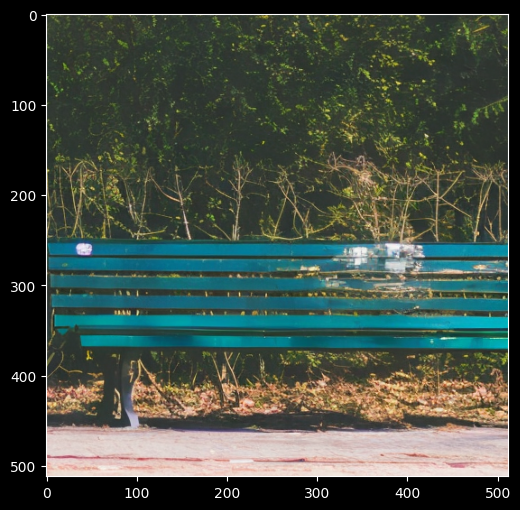

In [8]:
out_image = torch.cat([source_image * 0.5 + 0.5,
                       image[0:1],
                       image[-1:]], dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))

print("Syntheiszed images are saved in", out_dir)

img_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_ori)



In [ ]:
# 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(pred_x0_list_denoise[:10][i])
    ax.axis('off')  # 隐藏坐标轴

plt.show()